In [ ]:
import os

os.environ['DDE_BACKEND'] = 'tensorflow'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(42)
np.random.seed(42)

from deepxde.data import PDE
from deepxde.geometry import TimeDomain
from deepxde.icbc.initial_conditions import IC
from deepxde.icbc import PointSetBC
from deepxde.nn import FNN, PFNN
from deepxde.model import Model
from deepxde.callbacks import VariableValue, EarlyStopping
from deepxde.metrics import mean_squared_error, l2_relative_error
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

from tensorflow.keras.optimizers.schedules import InverseTimeDecay

import sys
sys.path.append('../..')
from utils.custom_models import AdaptativeDataWeightModel

Set the default float type to float64


In [12]:


def sir_system(t, compartments, gamma):
    S, I, R = compartments
    return [
        -beta_t(t) * S * I,
        beta_t(t) * S * I - gamma * I,
        gamma * I
    ]

In [13]:
t0, tf = 0, 50

beta_t = lambda t: t**2 / 10000 + 0.25

gamma = 0.1
S0, I0, R0 = 0.99, 0.01, 0.0

In [14]:
sir_sol = solve_ivp(
    sir_system,
    [t0, tf],
    [S0, I0, R0],
    args=[gamma],
    dense_output=True
)

nop_data = 40
train_t = np.linspace(t0, tf, nop_data)
sir_data = sir_sol.sol(train_t).T

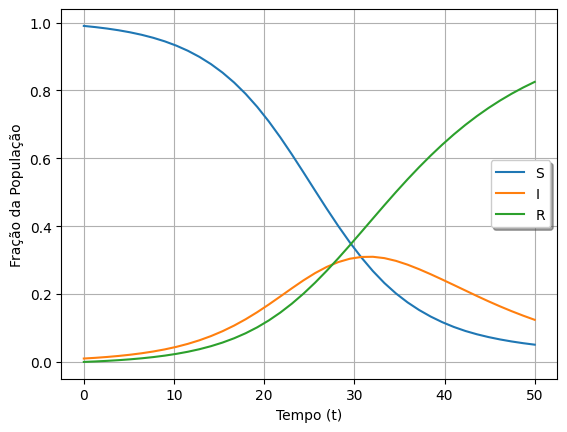

In [15]:
plt.plot(train_t, sir_data)
plt.legend(["S", "I", "R"], shadow=True)
plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")
plt.grid()
plt.savefig("../../images/rk-predicted-compartments-mono-beta.png")
plt.show()

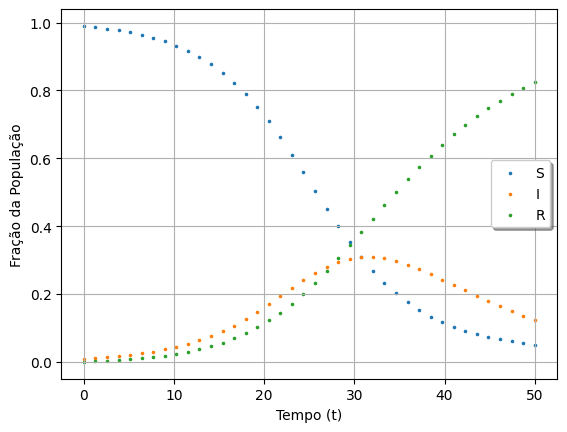

In [16]:
plt.scatter(train_t, sir_data[:, 0], s=2.5)
plt.scatter(train_t, sir_data[:, 1], s=2.5)
plt.scatter(train_t, sir_data[:, 2], s=2.5)
plt.legend(["S", "I", "R"], shadow=True)
plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")
plt.grid()
plt.savefig("../../images/rk-data-mono-beta.png")
plt.show()

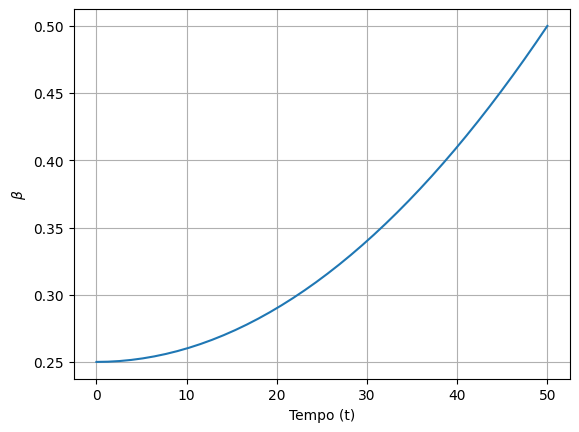

In [17]:

plt.plot(train_t, beta_t(train_t))
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.grid()
plt.savefig("../../images/real-beta-mono-beta.png")
plt.show()

In [18]:
# I_min, I_max = data_I.min(axis=0), data_I.max(axis=0)
# I_mean, I_std = data_I.mean(axis=0), data_I.std(axis=0)

# # Min/Max
# def scale(data):
#     return (data - I_min) / (I_max - I_min)

# def unscale(data):
#     return I_min + (I_max - I_min) * data

In [19]:
timeinterval = TimeDomain(t0, tf)

def sir_residual(t, y):
    S, I, beta = y[:,0:1], y[:,1:2], y[:,2:3]

    dS_dt = dde.gradients.jacobian(y, t, i=0)
    dI_dt = dde.gradients.jacobian(y, t, i=1)
    
    return [
        dS_dt + beta * S * I,
        dI_dt - beta * S * I + gamma * I
    ]

# Tensorflow has an issue with lambdas...
def is_on_initial(_, on_initial): return on_initial
def S0_val(_): return S0
def I0_val(_): return I0

ic_S = IC(timeinterval, S0_val, is_on_initial, component=0)
ic_I = IC(timeinterval, I0_val, is_on_initial, component=1)

data_t = train_t.reshape(-1, 1)
data_S = PointSetBC(data_t, sir_data[:,0:1], component=0)
data_I = PointSetBC(data_t, sir_data[:,1:2], component=1)

ics = [ic_S, ic_I]
data_conds = [
    data_I 
] 

conditions = ics + data_conds

data = PDE(
    timeinterval, 
    sir_residual, 
    conditions,
    num_domain=128,
    num_boundary=2,
    num_test=32,
    anchors=data_t
)

n_hidden_layers = 4
hidden_layer_size = 50
topology = [1] + [hidden_layer_size] * n_hidden_layers + [3]
# activation = ["tanh"] * n_hidden_layers + ["sigmoid"]

activation = "tanh"
initializer = "Glorot uniform"
optimizer = "adam"
lr = 0.002

eq_w = 1
ic_w = 1
data_w = 1

n_equations = 2

loss_weights = [eq_w] * n_equations + [ic_w] * len(ics) + [data_w] * len(data_conds)

# net = FNN(
#     topology, 
#     activation, 
#     initializer
# )

net = PFNN(
    topology, 
    activation, 
    initializer
)

model = Model(data, net)
# model = AdaptativeDataWeightModel(data, net, n_physics=n_equations + len(ics), n_data=1)

model.compile(
    optimizer, 
    lr,
    loss_weights=loss_weights
)


Compiling model...
'compile' took 0.016515 s



In [20]:
early_stopping = EarlyStopping(min_delta=1e-7, patience=5000)

losshistory, train_state = model.train(
    iterations=100000, 
    display_every=100,
    callbacks=[early_stopping]
)

# model.compile(
#     "L-BFGS", 
#     loss_weights=loss_weights
# )

# dde.optimizers.set_LBFGS_options(
#     # ftol=np.finfo(float).eps,
#     maxiter=25000,
#     ftol=1e-10,
#     gtol=1e-12
# )

# losshistory, train_state = model.train(
#     iterations=20000, 
#     display_every=100
# )

Training model...

0         [5.40e-05, 4.57e-03, 9.80e-01, 1.00e-04, 1.81e-01]    [5.28e-05, 1.30e-03, 9.80e-01, 1.00e-04, 1.81e-01]    []  
100       [1.25e-04, 1.03e-04, 2.70e-06, 1.57e-07, 2.45e-03]    [1.01e-04, 9.14e-05, 2.70e-06, 1.57e-07, 2.45e-03]    []  
200       [6.19e-05, 4.55e-05, 5.10e-10, 1.22e-07, 1.71e-03]    [4.94e-05, 4.45e-05, 5.10e-10, 1.22e-07, 1.71e-03]    []  
300       [4.92e-05, 3.26e-05, 1.55e-09, 5.07e-08, 9.08e-04]    [3.99e-05, 3.36e-05, 1.55e-09, 5.07e-08, 9.08e-04]    []  
400       [3.43e-05, 2.66e-05, 8.03e-10, 3.42e-07, 8.57e-04]    [2.71e-05, 2.43e-05, 8.03e-10, 3.42e-07, 8.57e-04]    []  
500       [2.70e-05, 1.45e-05, 1.81e-09, 3.45e-08, 4.67e-04]    [2.10e-05, 1.51e-05, 1.81e-09, 3.45e-08, 4.67e-04]    []  
600       [1.78e-05, 2.89e-05, 1.28e-08, 4.17e-06, 1.02e-03]    [1.25e-05, 2.47e-05, 1.28e-08, 4.17e-06, 1.02e-03]    []  
700       [2.13e-05, 1.04e-05, 1.03e-09, 5.71e-08, 2.18e-04]    [1.51e-05, 1.09e-05, 1.03e-09, 5.71e-08, 2.18e-04]    []

In [21]:
model.save("../../models/mono-beta")

'../../models/mono-beta-13400.weights.h5'

In [22]:
dde.saveplot(
    losshistory, 
    train_state, 
    issave=True, 
    isplot=False,
    output_dir="../../losses", 
    loss_fname=f"loss-mono-beta",
    train_fname=f"train-mono-beta",
    test_fname=f"test-mono-beta")

Saving loss history to ../../losses/loss-mono-beta ...
Saving training data to ../../losses/train-mono-beta ...
Saving test data to ../../losses/test-mono-beta ...


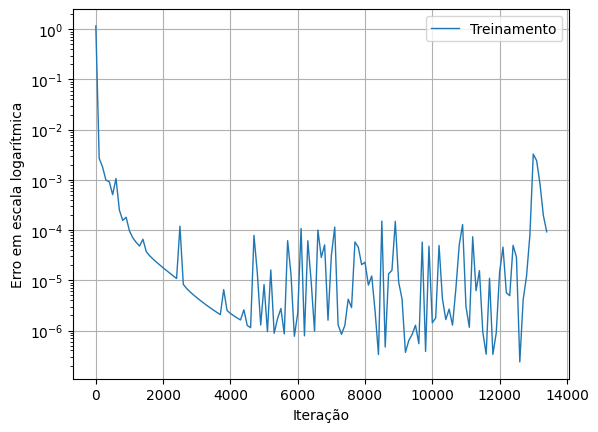

In [23]:
train = np.sum(losshistory.loss_train, axis=1)
test = np.sum(losshistory.loss_test, axis=1)

plt.semilogy(losshistory.steps, train, "-", label="Treinamento", linewidth=1)
# plt.semilogy(losshistory.steps, train, "o-", label="Treinamento", linewidth=2)
# plt.semilogy(losshistory.steps, test, "x-", label="Teste", linewidth=2)

plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
plt.savefig(f"../../images/loss-mono-beta.png")
plt.show()

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/gabriel/inverse-compmodel/lib/python3.11/site-packages/tensorflow/python/ops/while_loop.py", line 488, in while_loop
    loop_vars = body(*loop_vars)  File "/home/gabriel/inverse-compmodel/lib/python3.11/site-packages/tensorflow/python/ops/while_loop.py", line 479, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/home/gabriel/inverse-compmodel/lib/python3.11/site-packages/tensorflow/python/ops/functional_ops.py", line 653, in compute
    return (next_i, flat_a_out, tas)  File "/home/gabriel/inverse-compmodel/lib/python3.11/site-packages/tensorflow/python/ops/functional_ops.py", line 648, in <listcomp>
    tas = [ta.write(i, value) for (ta, value) in zip(tas, flat_a_out)]  File "/home/gabriel/inverse-compmodel/lib/python

ValueError: x and y must have same first dimension, but have shapes (40,) and (100,)

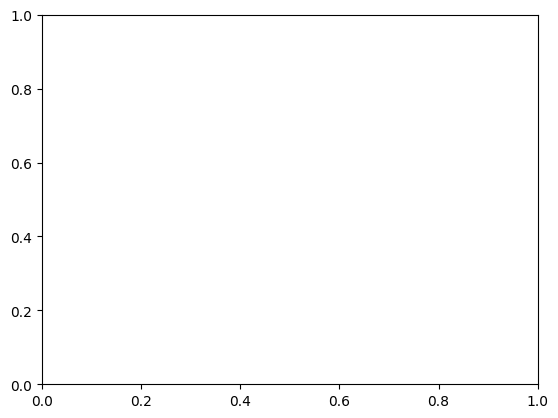

In [24]:
plt.rcParams['text.usetex'] = False
nop_test = 100

test_t = np.linspace(t0, tf, nop_test).reshape(-1, 1)
y_pred = model.predict(test_t)

S_pred, I_pred = y_pred[:, 0], y_pred[:, 1]
R_pred = 1 - S_pred - I_pred  

sir_test = sir_sol.sol(test_t.reshape(nop_test)).T

S_real = sir_test[:,0]
I_real = sir_test[:,1]
R_real = sir_test[:,2]

plt.plot(train_t, S_real, label="S RK", color="blue")
plt.plot(train_t, I_real, label="I RK", color="red")
plt.plot(train_t, R_real, label="R RK", color="green")

plt.scatter(train_t, sir_data[:,0], label="Dados S", color="blue", s=2.5)
plt.scatter(train_t, sir_data[:,1], label="Dados I", color="red", s=2.5)
plt.scatter(train_t, sir_data[:,2], label="Dados R", color="green", s=2.5)

plt.plot(test_t, S_pred, label="S previsto", linestyle="--", color="blue")
plt.plot(test_t, I_pred, label="I previsto", linestyle="--", color="red")
plt.plot(test_t, R_pred, label="R previsto", linestyle="--", color="green")

plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")

plt.legend()
plt.grid()
plt.savefig("../../images/predicted-compartments-mono-beta.png")

plt.show()

[]

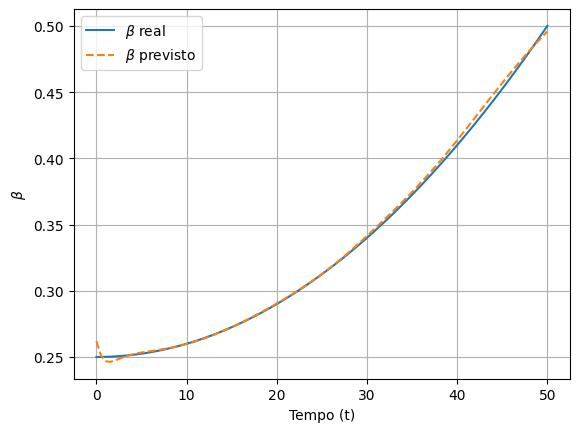

In [ ]:
beta_pred = y_pred[:, 2]
beta_real = beta_t(test_t)
plt.plot(test_t, beta_real, label=r"$\beta$ real")
plt.plot(test_t, beta_pred, label=r"$\beta$ previsto", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.legend()
plt.grid()
plt.savefig("../../images/predicted-beta-mono-beta.png")
plt.plot()

In [ ]:
sir_test = sir_sol.sol(test_t.reshape(nop_test)).T

S_real = sir_test[:,0]
I_real = sir_test[:,1]
R_real = 1 - S_real - I_real

### MSE

In [ ]:
mean_squared_error(S_real, S_pred)

2.7451680063083127e-08

In [ ]:
mean_squared_error(I_real, I_pred)

2.433668824288095e-09

In [ ]:
mean_squared_error(R_real, R_pred)

2.0279699003794592e-08

In [ ]:
mean_squared_error(beta_real, beta_pred)

5.840541529964948e-06

## L2

In [ ]:
l2_relative_error(S_real, S_pred)

np.float64(0.00026086796037540845)

In [ ]:
l2_relative_error(I_real, I_pred)

np.float64(0.00025517417192153543)

In [ ]:
l2_relative_error(R_real, R_pred)

np.float64(0.00033717394714850467)

In [ ]:
l2_relative_error(beta_real, beta_pred)

np.float64(3.1327577832256575)

## L-Infinity

In [ ]:
np.max(np.abs(S_real - S_pred))

np.float64(0.00037903328833291394)

In [ ]:
np.max(np.abs(I_real - I_pred))

np.float64(0.0001279353113665116)

In [ ]:
np.max(np.abs(R_real - R_pred))

np.float64(0.00029922051249220427)

In [ ]:
np.max(np.abs(beta_real - beta_pred))

np.float64(0.2537227009061114)